In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.dpi'] = 120

In [3]:
fetal = pd.read_csv('fetal_health.csv')

### EDA

In [4]:
fetal.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

In [5]:
fetal['fetal_health'] = fetal['fetal_health'].astype('category')

In [6]:
cols = {}
for i, f in enumerate(fetal.columns):
    print(i, f)

0 baseline value
1 accelerations
2 fetal_movement
3 uterine_contractions
4 light_decelerations
5 severe_decelerations
6 prolongued_decelerations
7 abnormal_short_term_variability
8 mean_value_of_short_term_variability
9 percentage_of_time_with_abnormal_long_term_variability
10 mean_value_of_long_term_variability
11 histogram_width
12 histogram_min
13 histogram_max
14 histogram_number_of_peaks
15 histogram_number_of_zeroes
16 histogram_mode
17 histogram_mean
18 histogram_median
19 histogram_variance
20 histogram_tendency
21 fetal_health


In [7]:
fetal = fetal.drop(fetal.columns[list(range(11, 21))], axis=1)

In [8]:
fetal.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
fetal_health                                              0
dtype: int64

In [9]:
len(fetal)

2126

In [10]:
fetal.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000


In [11]:
y = fetal['fetal_health']

In [12]:
numeric_cols = fetal.select_dtypes(include=[np.number]).columns
X = fetal[numeric_cols].apply(zscore)

In [13]:
fetal = X
fetal['fetal_health'] = y

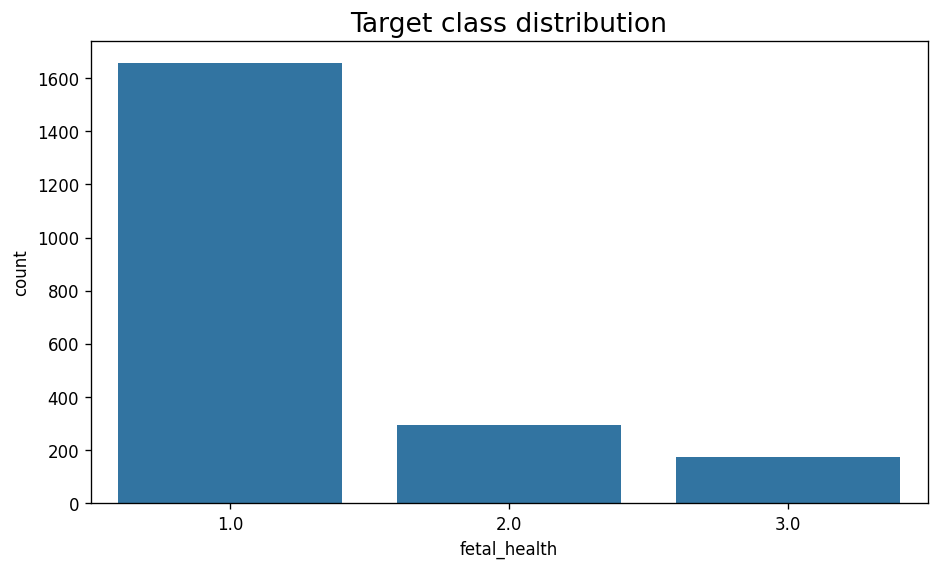

In [14]:
tgt_class = sns.countplot(data=fetal, x='fetal_health')
tgt_class.axes.set_title('Target class distribution', fontsize=16)
plt.show()

### Classification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [16]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [17]:
adas = ADASYN(random_state=42)
X_train_os, y_train_os = adas.fit_resample(X_train, y_train)

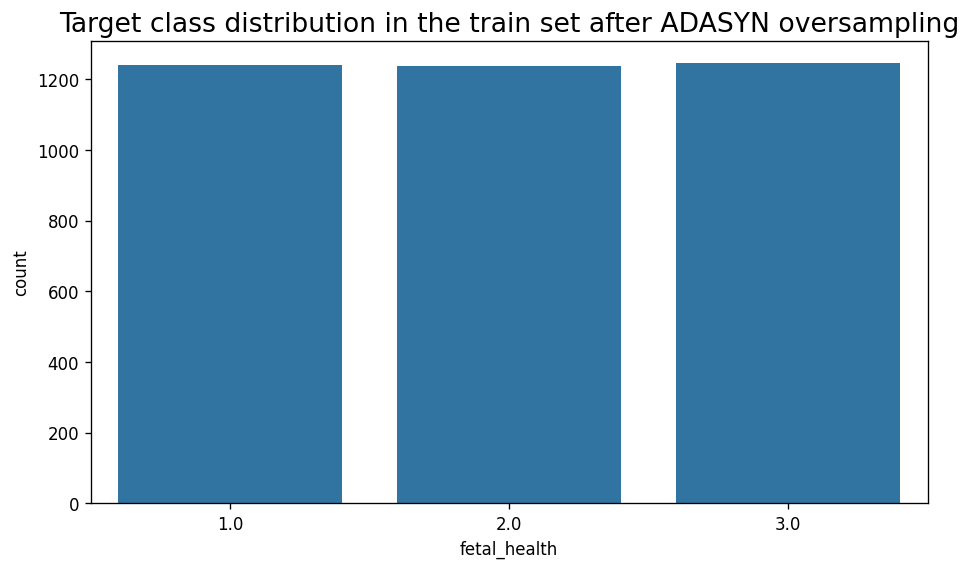

In [18]:
tgt_class = sns.countplot(data=X_train_os, x='fetal_health')
tgt_class.axes.set_title('Target class distribution in the train set after ADASYN oversampling', fontsize=16)
plt.show()

In [19]:
X_test = X_test[numeric_cols]
X_train_os = X_train_os[numeric_cols]

In [20]:
def visClass(hue_pred, method):

    class_colors = {1.0: 'rebeccapurple', 2.0: 'mediumorchid', 3.0: 'plum'}

    plt.figure()
    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_test['baseline value'], y=X_test['abnormal_short_term_variability'], hue=y_test, palette=class_colors, legend='full')
    plt.title('True Labels')
    plt.xlabel('baseline value')
    plt.ylabel('abnormal_short_term_variability')

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_test['baseline value'], y=X_test['abnormal_short_term_variability'], hue=hue_pred, palette=class_colors, legend='full')
    plt.title(f'Predicted Labels ({method})')
    plt.xlabel('baseline value')
    plt.ylabel('abnormal_short_term_variability')

    ax2.get_legend().remove()
    ax1.get_legend().remove()

    handles, labels = ax2.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=len(labels))

    plt.show()

Multinomial logistic regression

In [122]:
lr = LogisticRegression(random_state=42).fit(X_train_os, y_train_os) # model handles multinomial by default
lr_pred = lr.predict(X_test)

In [123]:
accuracy_score(y_test, lr_pred)

0.7575187969924813

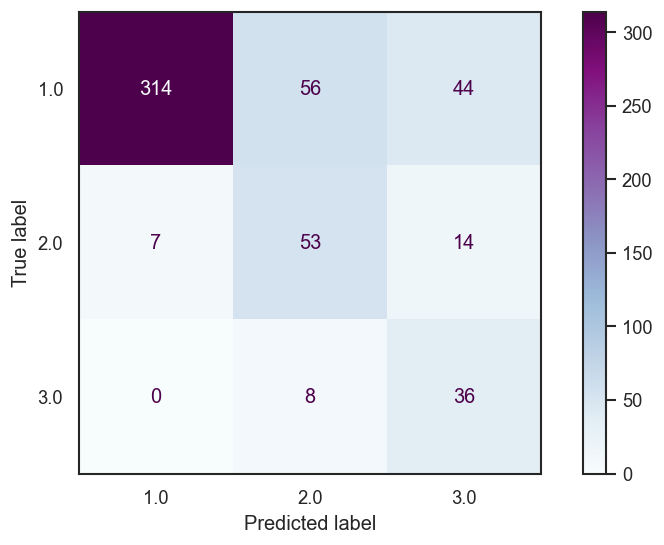

In [179]:
lr_cm = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
lr_cmd = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr.classes_)
lr_cmd.plot(cmap='BuPu')
plt.show()

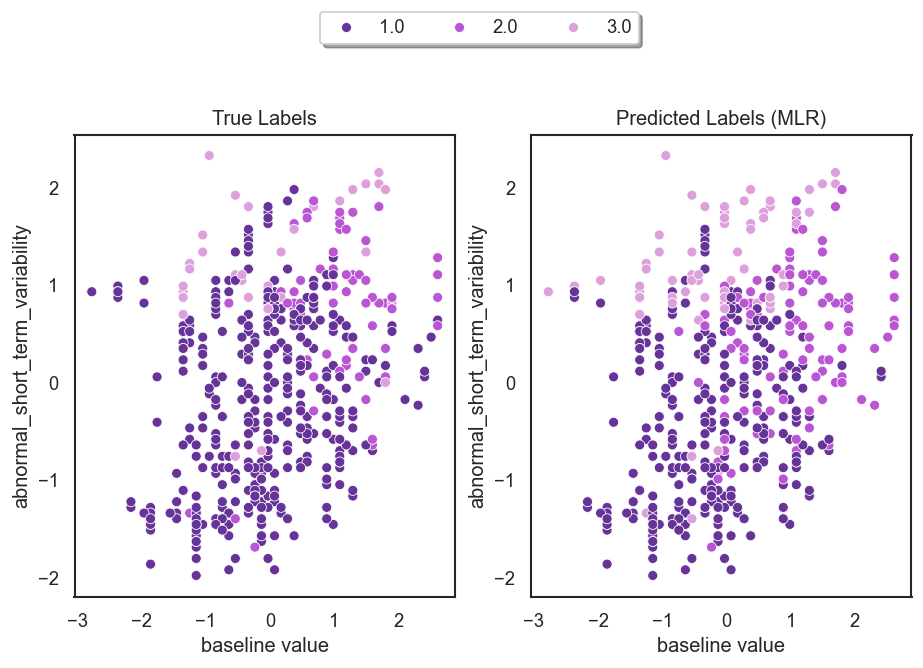

In [188]:
visClass(lr_pred, 'MLR')

KNN

In [127]:
knn = KNeighborsClassifier(algorithm='auto')

knn_params = {
    'n_neighbors': list(range(1, 11)),
    'leaf_size': list(range(20, 41)), # passed to BallTree or KDTree if they're chosen as algorithm
    'p': [1, 2], # 1 - manhattan, 2 - euclidean
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev']}

gs_knn= GridSearchCV(
    estimator=knn,
    param_grid=knn_params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

gs_knn.fit(X_train_os, y_train_os)

print(gs_knn.best_params_ ) 

knn_pred = gs_knn.predict(X_test)

{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


In [130]:
accuracy_score(y_test, knn_pred)

0.8966165413533834

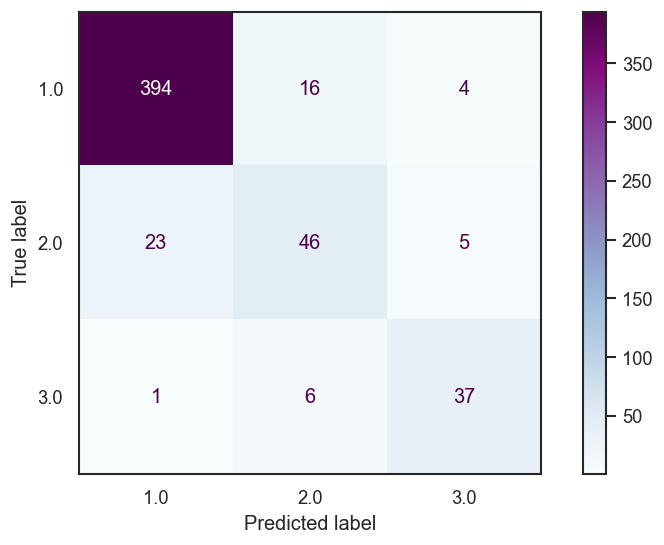

In [180]:
knn_cm = confusion_matrix(y_test, knn_pred, labels=gs_knn.classes_)
knn_cmd = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=gs_knn.classes_)
knn_cmd.plot(cmap='BuPu')
plt.show()

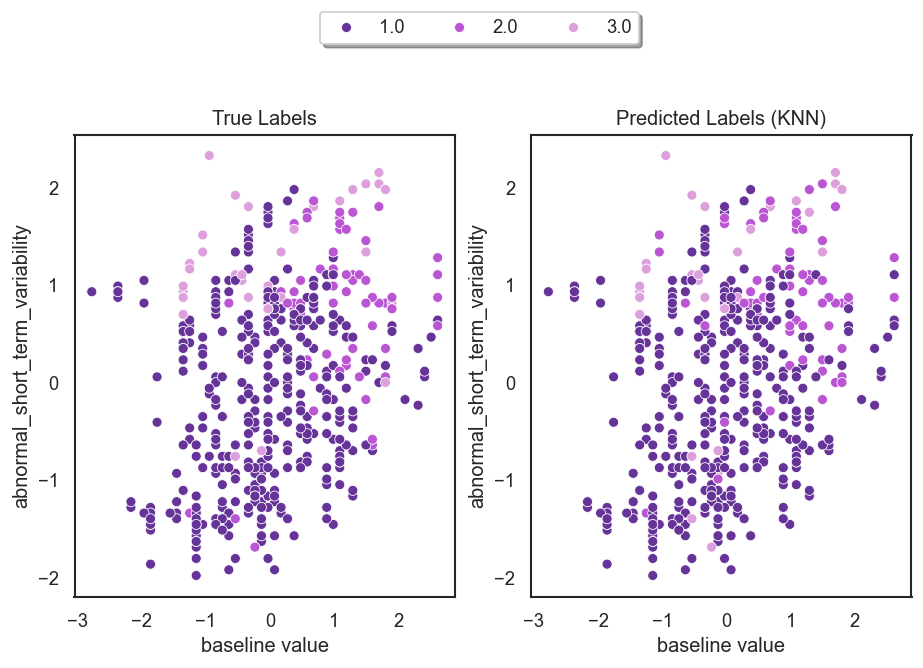

In [189]:
visClass(knn_pred, 'KNN')

SVM

In [134]:
svm = SVC(random_state=42)

svm_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'], # kernel coefficient, scale = 1/n * X_var, auto = 1/n
    'C': [0.1, 1, 10], # regularization parameter
    'degree': list(range(1, 7)) # applicable to poly kernel
}

gs_svm = GridSearchCV(
    estimator=svm,
    param_grid=svm_params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

gs_svm.fit(X_train_os, y_train_os)

print(gs_svm.best_params_ ) 

svm_pred = gs_svm.predict(X_test)

{'C': 10, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [135]:
accuracy_score(y_test, svm_pred)

0.8665413533834586

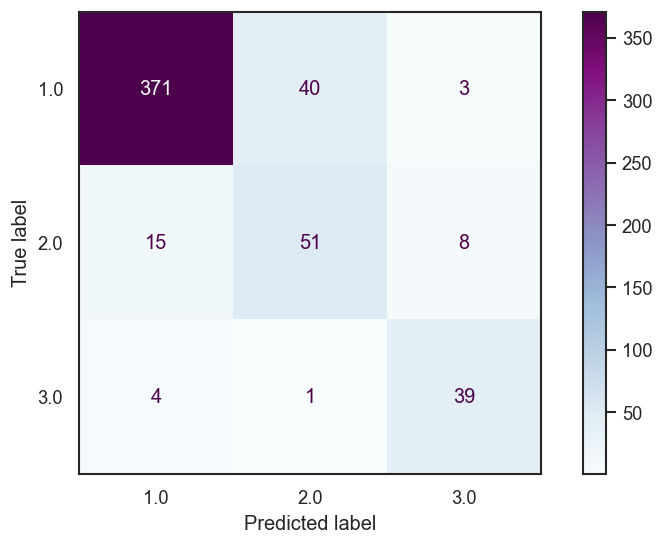

In [181]:
svm_cm = confusion_matrix(y_test, svm_pred, labels=gs_svm.classes_)
svm_cmd = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=gs_svm.classes_)
svm_cmd.plot(cmap='BuPu')
plt.show()

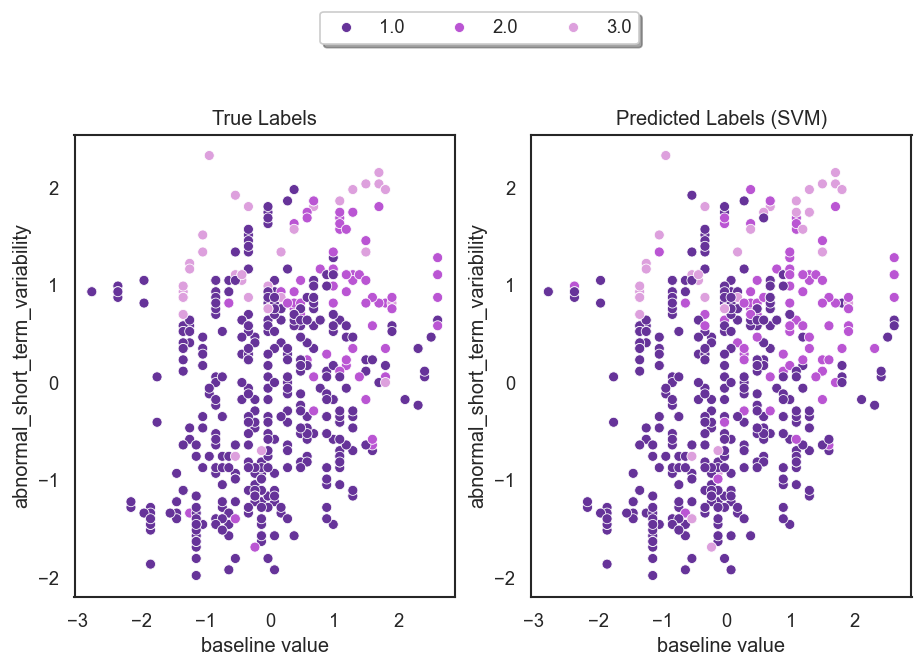

In [186]:
visClass(svm_pred, 'SVM')

Decision tree

In [199]:
list(range(2, 42, 5))

[2, 7, 12, 17, 22, 27, 32, 37]

In [52]:
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'], # strategy of node splitting
    'max_depth': list(range(10, 101, 10)), 
    'min_samples_split': list(range(2, 42, 5)), # minimum number of samples required to split a node
    'max_features': ['sqrt', 'log2', None], # number of features to consider when looking for the best split
    'ccp_alpha': np.arange(0, 0.5, 0.2) # pruning
}

gs_dt = GridSearchCV(
    estimator=dt,
    param_grid=dt_params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

gs_dt.fit(X_train_os, y_train_os)

print(gs_dt.best_params_ ) 

dt_pred = gs_dt.predict(X_test)

{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}


In [53]:
accuracy_score(y_test, dt_pred)

0.9172932330827067

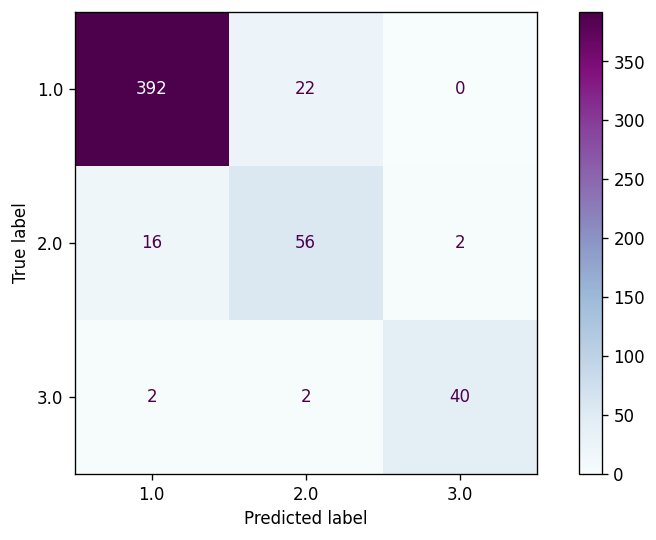

In [54]:
dt_cm = confusion_matrix(y_test, dt_pred, labels=gs_dt.classes_)
dt_cmd = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=gs_dt.classes_)
dt_cmd.plot(cmap='BuPu')
plt.show()

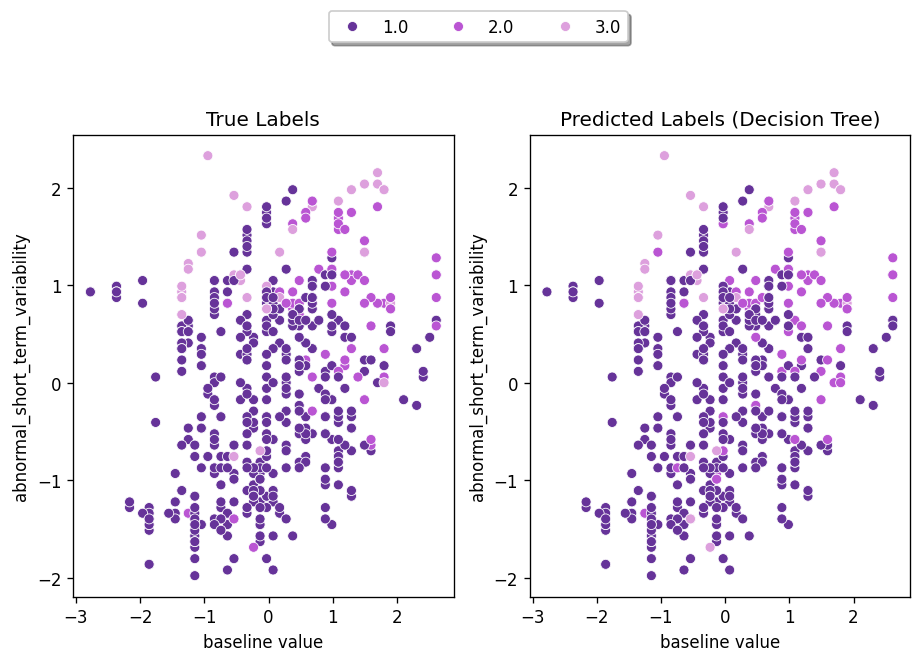

In [55]:
visClass(dt_pred, 'Decision Tree')

Random Forest

In [45]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': list(range(100, 301, 100)),
    'max_depth': list(range(10, 101, 10)), 
}

gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

gs_rf.fit(X_train_os, y_train_os)

print(gs_rf.best_params_ )

{'max_depth': 30, 'n_estimators': 200}


In [46]:
rf_pred = gs_rf.predict(X_test)

In [47]:
accuracy_score(y_test, rf_pred)

0.9285714285714286

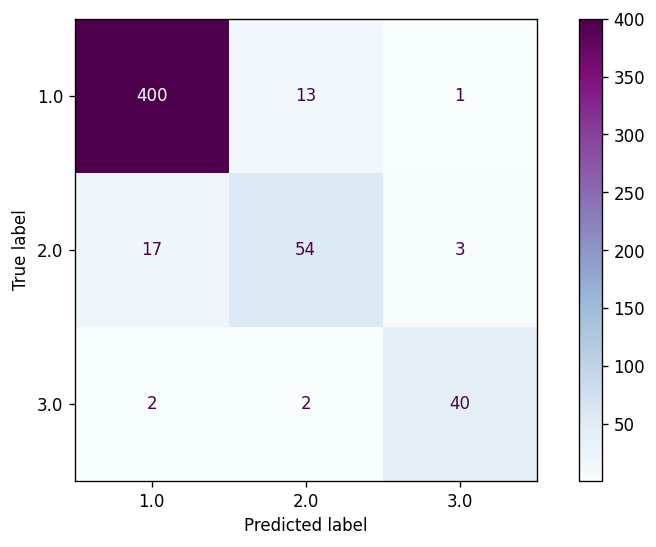

In [48]:
rf_cm = confusion_matrix(y_test, rf_pred, labels=gs_rf.classes_)
rf_cmd = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=gs_rf.classes_)
rf_cmd.plot(cmap='BuPu')
plt.show()

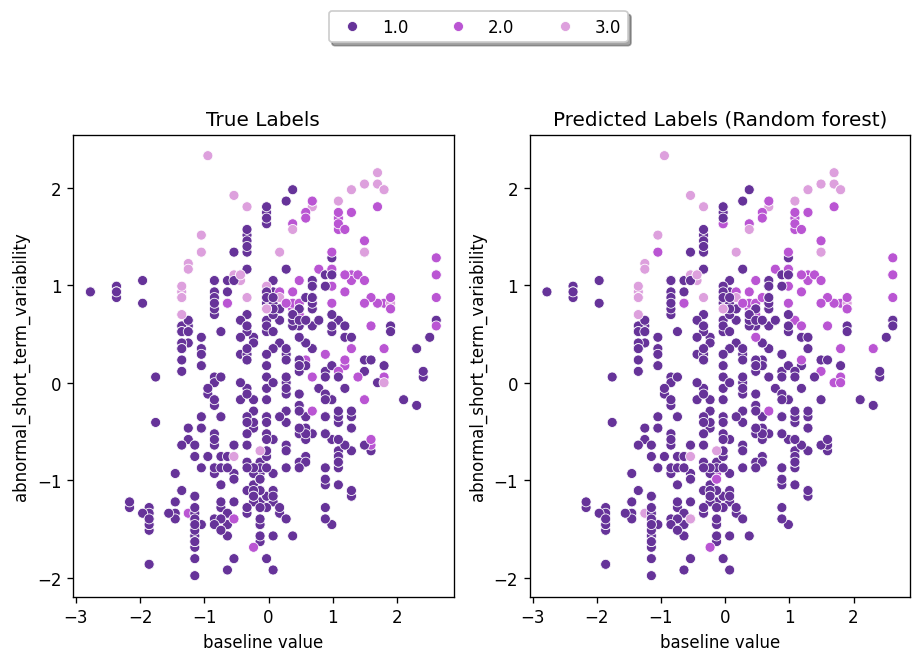

In [49]:
visClass(rf_pred, 'Random forest')

Neural Network

In [57]:
nn = MLPClassifier(random_state=42)

nn_params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]
}

gs_nn = GridSearchCV(
    estimator=nn,
    param_grid=nn_params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

gs_nn.fit(X_train_os, y_train_os)

print(gs_nn.best_params_ )

{'activation': 'relu', 'hidden_layer_sizes': (50, 100, 50)}


In [58]:
nn_pred = gs_nn.predict(X_test)

In [59]:
accuracy_score(y_test, nn_pred)

0.9304511278195489

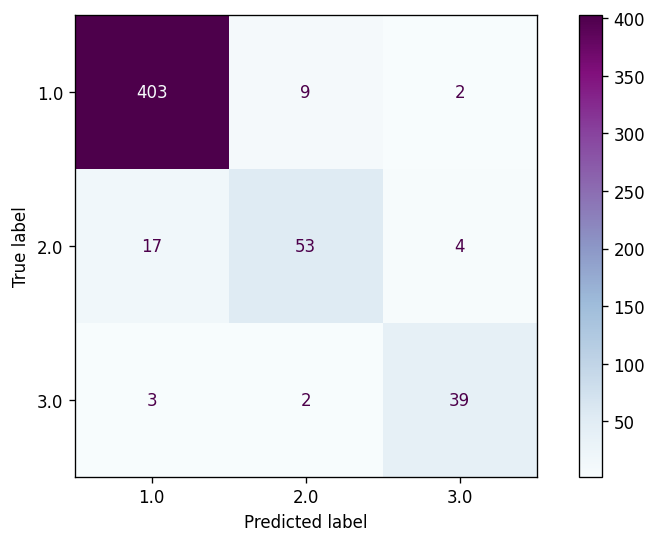

In [60]:
nn_cm = confusion_matrix(y_test, nn_pred, labels=gs_nn.classes_)
nn_cmd = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=gs_nn.classes_)
nn_cmd.plot(cmap='BuPu')
plt.show()

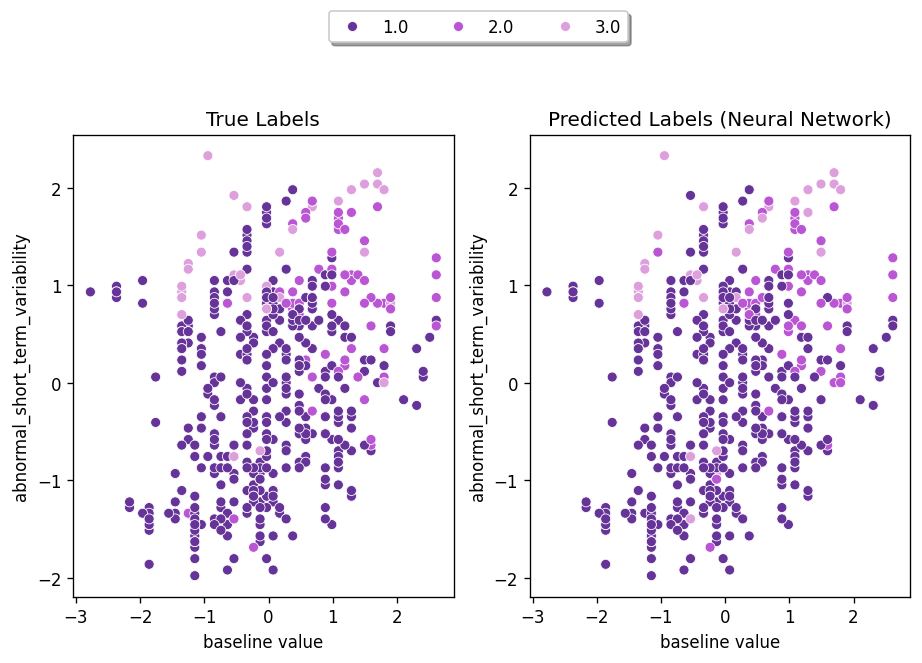

In [61]:
visClass(nn_pred, 'Neural Network')